# BM-GEV fitting

This example shows the BM-GEV fitting to derive the extreme event. 

---

Load the packages

In [1]:
import pandas as pd
import pybtls as pb
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genextreme

We generate 100-year traffic data (250 business days per year) first. 

The simulation setup follows a similar logic to the previous Simulation with Traffic Generation example, but is simplified.

In [ ]:
# Define the influence line
le = pb.InfluenceLine("built-in")
le.set_IL(id = 1, length = 20.0)

# Set bridge
bridge = pb.Bridge(length=20.0, no_lane=2)
bridge.add_load_effect(inf_line_surf=le)

# Set vehicle generator
garage = pb.garage.read_garage_file("./garage.txt", 4)
kernel = [[1.0, 0.08], [1.0, 0.05], [1.0, 0.02]]
vehicle_gen = pb.VehicleGenGarage(garage=garage, kernel=kernel)

# Set headway generator
headway_gen = pb.HeadwayGenFreeflow()

# Set lane flow compositions
normalized_hourly_flow_truck = [0.019947, 0.019947, 0.019947, 0.019947, 0.019947, 0.031915, 0.059840, 0.059840, 0.059840, 0.055851, 0.046543, 0.046543, 0.046543, 0.046543, 0.046543, 0.055851, 0.055851, 0.055851, 0.055851, 0.046543, 0.046543, 0.031915, 0.031915, 0.019947]
normalized_hourly_flow_car = [0.005721, 0.005721, 0.005721, 0.005721, 0.005721, 0.014874, 0.088673, 0.145881, 0.117277, 0.061785, 0.037185, 0.037185, 0.037185, 0.037185, 0.037185, 0.061785, 0.061785, 0.061785, 0.061785, 0.037185, 0.037185, 0.014874, 0.014874, 0.005721]

lfc_1 = pb.LaneFlowComposition(lane_index=1, lane_dir=1)
lfc_1.assign_lane_data(
    hourly_truck_flow = [
        round(i * 2500) for i in normalized_hourly_flow_truck
    ], 
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [5.0] * 24,  # in dm/s
)

lfc_2 = pb.LaneFlowComposition(lane_index=2, lane_dir=1)
lfc_2.assign_lane_data(
    hourly_truck_flow = [
        round(i * 625) for i in normalized_hourly_flow_truck
    ],
    hourly_car_flow = [
        round(i * 14000) for i in normalized_hourly_flow_car
    ],
    hourly_speed_mean = [80 / 3.6 * 10] * 24,  # in dm/s
    hourly_speed_std = [10.0] * 24,  # in dm/s
)    

# Set traffic generator
traffic_gen = pb.TrafficGenerator(no_lane=2)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_1)
traffic_gen.add_lane(vehicle_gen=vehicle_gen, headway_gen=headway_gen, lfc=lfc_2)

# Selet outputs
output_config = pb.OutputConfig()
output_config.set_BM_output(
    write_summary = True,
    block_size_days = 250,
)

# Create and run the simulation
sim_task = pb.Simulation("./temp")
sim_task.add_sim(
    bridge = bridge,
    traffic = traffic_gen,
    no_day = 250*100,
    output_config = output_config,
    time_step = 0.1,
    tag = "Case5",
)
sim_task.run(no_core = 1)

# Get and save the output data
example_output = sim_task.get_output()
pb.save_output(example_output, "example_output_BM.pkl")

Read the BM output data.

In [ ]:
example_output = pb.load_output("example_output_BM.pkl")
BM_output = example_output["Case5"].read_data("BM_summary")["BM_S_20_Eff_1"]

Make a plot to the BM data. 

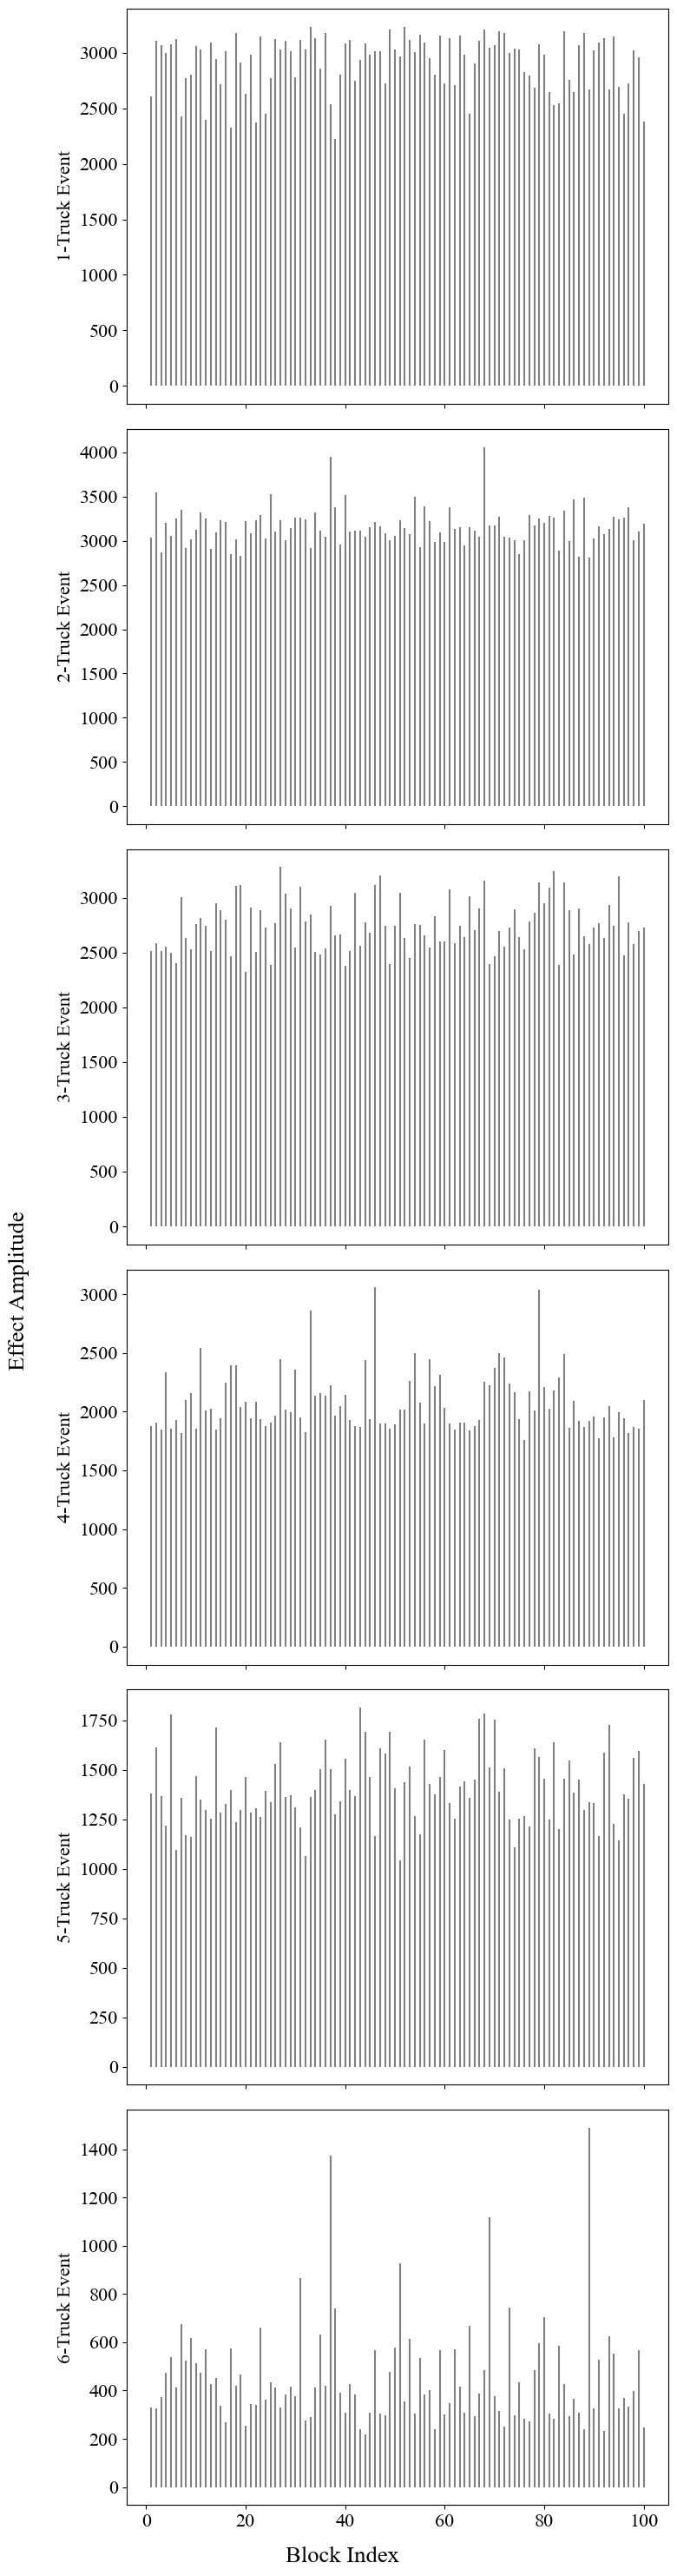

In [10]:
pb.plot.plot_BM_S(BM_output)

We define the following functions: 

In [ ]:
def fit_gev_exceedances(BM_data: pd.Series):
    # Fit GEV: returns shape c=-xi, loc=mu, scale=sigma
    c, mu, sigma = genextreme.fit(BM_data)
    xi = -c
    return xi, mu, sigma


def return_level(T, mu, sigma, xi):
        y = -np.log(1 - 1.0 / T)
        if np.isclose(xi, 0.0):
            return mu - sigma * np.log(np.log(1 / (1 - 1.0 / T)))  # = mu - sigma*log(y)
        return mu + (sigma / xi) * (y ** (-xi) - 1)


def plot_BM_GEV_pdf(BM_data: pd.Series, mu: float, sigma: float, xi: float):

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))

    plt.hist(BM_data, bins=40, density=True, color="#AAAAAA", edgecolor="gray", alpha=0.8, label="Annual maximum events")

    plt.xlabel("Mid-Span Bending Moment (kNm)")
    plt.ylabel("Density")

    # Fitted GEV PDF
    if np.isclose(xi, 0.0):
        x = np.linspace(BM_data.min(), BM_data.max(), 500)
    else:
        if xi > 0.0:
            x = np.linspace(mu - sigma / xi, BM_data.max(), 500)
        elif xi < 0.0:
            x = np.linspace(BM_data.min(), mu + sigma / abs(xi), 500)

    pdf = genextreme.pdf(x, -xi, loc=mu, scale=sigma)
    plt.plot(x, pdf, color="black", lw=2, label="GEV distribution fitted")
    
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_BM_GEV_probability(BM_data: pd.Series, mu: float, sigma: float, xi: float):

    def gumbel_variate(p):
        return -np.log(-np.log(p))

    x = BM_data
    n = len(BM_data)
    xs = np.sort(x)

    Fhat = np.arange(1, n+1, dtype=float) / (n + 1.0)
    yemp = gumbel_variate(Fhat)

    qfn = lambda p: mu + (sigma/xi) * ( (-np.log(1.0-p))**(-xi) - 1.0 ) if not np.isclose(xi, 0.0) else mu - sigma * np.log(-np.log(p))  # non-exceedance

    pgrid = np.linspace(0.005, 0.999, 500)  # p = 1/T, 1 - p -> non-exceedance
    xfit = qfn(pgrid)
    yfit = gumbel_variate(1.0 - pgrid)

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["mathtext.fontset"] = "stix"

    plt.figure(figsize=(8, 5))

    plt.scatter(xs, yemp, s=25, color="gray", label="Annual maximum events")
    plt.plot(xfit, yfit, color="black", lw=2.5, label="GEV distribution fitted")

    plt.xlabel("Mid-Span Bending Moment (kNm)")
    plt.ylabel("Standard GEV Variate")

    plt.grid()

    plt.legend()
    plt.tight_layout()
    plt.show()

The GEV models should be fitted separately for event groups defined by the number of trucks (see [this](https://arrow.tudublin.ie/cgi/viewcontent.cgi?article=1000&context=engschcivoth)). 

For a fit to be meaningful in this context, the data ought to follow a Type III GEV (Weibull) distribution with a finite upper endpoint. 

In the present example, events involving a single truck exhibit the expected Weibull behaviour, whereas multi-truck events do not. 

This suggests that events with more than one truck require longer simulation periods and larger block sizes to reveal the Weibull tail and yield stable GEV parameter estimates.


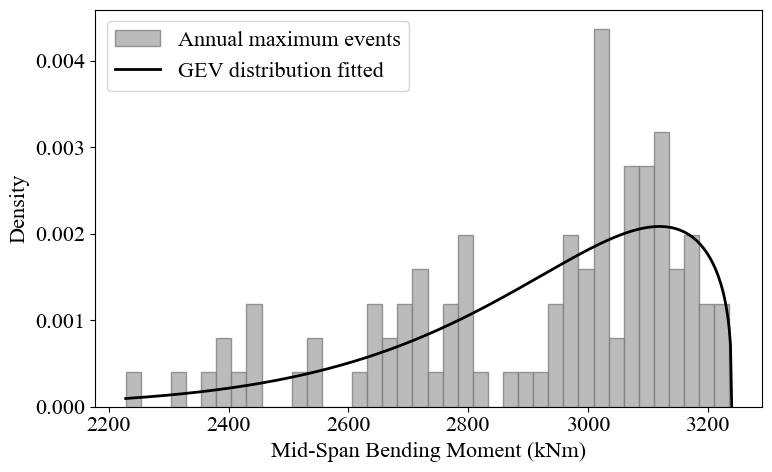

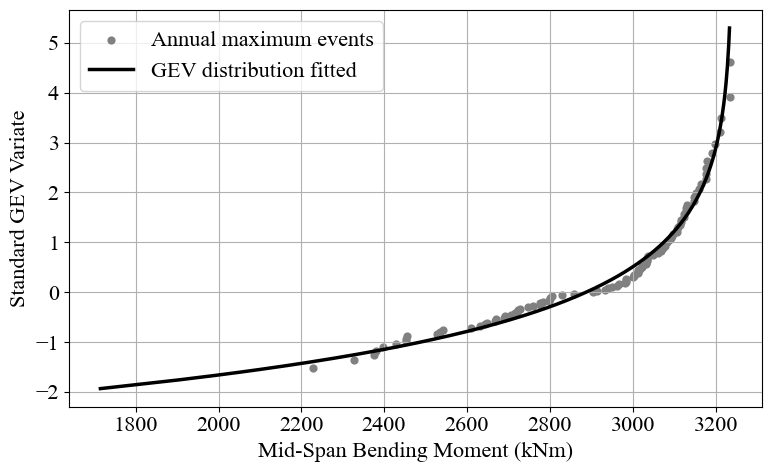

Fitted GEV distribution parameters:
xi: -0.7576, mu: 2887, sigma: 267


In [13]:
one_truck_data = BM_output["1-Truck Event"]

xi, mu, sigma = fit_gev_exceedances(one_truck_data)
plot_BM_GEV_pdf(one_truck_data, mu, sigma, xi)
plot_BM_GEV_probability(one_truck_data, mu, sigma, xi)

print("Fitted GEV distribution parameters:")
print(f"xi: {xi:.4f}, mu: {mu:.0f}, sigma: {sigma:.0f}")

Finally, we can use the fitted GEV parameters to estimate the extreme value for a 100-year event.

In [14]:
rl_100 = return_level(100, mu, sigma, xi)
print(f"Extreme value for 100-year event: {rl_100:.0f} kNm")

Extreme value for 100-year event: 3229 kNm
